# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [3]:
def H(y):
    # YOUR CODE HERE
    # if len(y) == 0:
    #     return 0
    # return float(pd.DataFrame(y).var(ddof=0))
    if len(y) == 0:
        return 0
    else:
        return np.sum(np.power((y - np.mean(y)), 2)) / len(y)

In [4]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [5]:
def Q(X, y, j, t):
    def R_r(selected_column, t, y):
        return len(y[selected_column > t]) * H(
            y[selected_column > t])

    def R_l(selected_column, t, y):
        return len(y[selected_column <= t]) * H(y[selected_column <= t])

    Q = 0
    selected_column = X[:, j]
    Q += R_l(selected_column, t, y) / len(y)
    Q += R_r(selected_column, t, y) / len(y)
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [6]:
class Node(object):
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        best_split_column = None
        best_threshold = None
        best_cost = H(y)
        # семинар 7
        best_information_gain = -999

        for split_column in range(X.shape[1]):

            x_col = X[:, split_column]

            for i_x in range(0, len(x_col)):

                threshold = x_col[i_x]

                information_gain = best_cost - Q(X, y, split_column, threshold)

                if information_gain > best_information_gain:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_information_gain = information_gain

        if best_information_gain == -999:
            return None, None, None, None, None, None

        x_col = X[:, best_split_column]
        X_left = X[x_col <= best_threshold, :]
        y_left = y[x_col <= best_threshold]
        X_right = X[x_col > best_threshold, :]
        y_right = y[x_col > best_threshold]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
        # семинар 7
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
            node.is_terminal = True
            return

        node.column = split_column
        node.threshold = threshold

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True

        self.tree_ = Node()
        #  если указать, то в следующем задании установить макс глубину 1 не получиться, то надо менять либо на 0, либо оставлять тут один и подавать на вход глубину 2 или я не понял задание...
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)

        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):

        if node.is_terminal:
            return node.prediction
        elif x[node.column] > node.threshold:
            return self.get_prediction(node.right, x)
        return self.get_prediction(node.left, x)

    def predict(self, X):
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [8]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

C:\anaconda\lib\site-packages\sklearn\utils\estimator_checks.py:3608: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 1.0 (renaming of 0.25) when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  warnings.warn(
C:\anaconda\lib\site-packages\sklearn\utils\estimator_checks.py:3652: FutureWarning: As of scikit-learn 0.23, estimators should have a 'requires_y' tag set to the appropriate value. The default value of the tag is False. An error will be raised from version 1.0 when calling check_estimator() if the tag isn't properly set.
  warnings.warn(warning_msg, FutureWarning)


### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model

In [9]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
x = data.data
y = data.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,
                                                    random_state=987)

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fun

Глубину поставил 2, так как классе у нас уже стоит глубина 1.

In [ ]:
model = MyDecisionTreeRegressor(max_depth=2)
model.fit(x_train, y_train)

MyDecisionTreeRegressor(max_depth=2)

In [ ]:
def plotting_scatter():
    # plt.rcParams["figure.figsize"] = (20,10)
    plt.scatter(x_l_col, y_l, color='blue')
    plt.scatter(x_r_col, y_r, color='green')
    plt.scatter(x_l_col, predict_y_l, color='orange')
    plt.scatter(x_r_col, predict_y_r, color='red')
    plt.axvline(my_threshold, color='maroon')

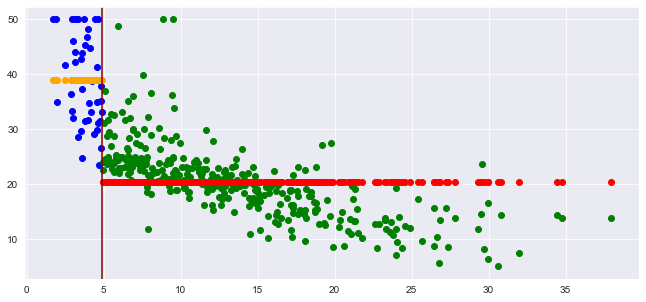

In [21]:
model_pred = model.predict(x_train)

my_threshold = model.tree_.threshold

needed_column = x_train[:, model.tree_.column]

x_l, y_l = x_train[needed_column <= my_threshold], y_train[needed_column <= my_threshold]

x_r, y_r = x_train[needed_column > my_threshold], y_train[needed_column > my_threshold]
predict_y_l, predict_y_r = model_pred[needed_column <= my_threshold], model_pred[needed_column > my_threshold]

x_l_col = x_l[:, model.tree_.column]
x_r_col = x_r[:, model.tree_.column]

plotting_scatter()

In [28]:
# from sklearn.tree import DecisionTreeRegressor
#
# plt.figure(figsize=(30, 30))
# from sklearn import tree
# model = DecisionTreeRegressor()
# model.fit(x_train, y_train)
#
# _ = tree.plot_tree(model,
#                    filled=True)
# plt.show()


KeyboardInterrupt



### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [ ]:
def mae(predict, target):
    y_true, predictions = np.array(target), np.array(predict)
    return np.mean(np.abs(y_true - predictions))


In [ ]:
# %%time
#
# '''
# Лучший MAE: -3.059449461801575
# CPU times: total: 1min 14s
# Wall time: 1min 15s
# '''
#
#
#
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import GridSearchCV
#
# # Если не делать make_scorer у меня кросс-вал час обучалась, не знаю с чем это связно, в ячейке ниже записаны те тайминги..
#
# folds = 5
# params = {'max_depth':range(1, 10, 2), 'min_samples_leaf':range(1, 10, 2)}
# my_tree = MyDecisionTreeRegressor()
# cross_val = GridSearchCV(my_tree, params, cv=folds, scoring=make_scorer(mae, greater_is_better=False), verbose=5)
# cross_val.fit(x_train, y_train)
# print('Лучшая глубина и min_samples_leaf:', cross_val.best_params_)
# print()
# print('Лучший MAE:', cross_val.best_score_)

Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 2}

Лучший счет: -4.477892111095516

CPU times: total: 1h 2min 35s
Wall time: 1h 2min 56s

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points

**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [ ]:
def creating_nan_array(x):
    arr = np.empty(len(x))
    arr[:] = np.NaN
    return arr

In [ ]:
def first_step(x):
    return np.random.choice(len(x), len(x))

In [ ]:
def second_step(bootsrap, x):
    return np.arange(len(x))[np.invert(np.isin(np.arange(len(x)), bootsrap))]

In [ ]:
def third_step(bootsrap, estimator, out_of_bag, x, y):
    estimator.fit(x[bootsrap, :], y[bootsrap])
    predicted = estimator.predict(x[out_of_bag, :])
    return predicted

In [ ]:
def concate_numpy_arr(out_of_bag, predicted, total_arr_pred, x):
    my_arr_nan = creating_nan_array(x)
    np.put(my_arr_nan, out_of_bag, predicted)
    total_arr_pred = np.column_stack((total_arr_pred, my_arr_nan))
    return total_arr_pred

In [ ]:
def forth_step(total_arr_pred, y):
    bias = np.square(y - np.nanmean(total_arr_pred, axis=1))
    var = np.nanvar(total_arr_pred, axis=1)
    return bias, var

In [ ]:
def fifth_step(bias, var):
    return np.nanmean(bias), np.nanmean(var)

In [ ]:
def get_bias_variance(estimator, x, y, n_iter):
    np.random.seed(987)
    # total_arr_pred = np.array([np.NaN for element in range(len(x))])

    total_arr_pred = creating_nan_array(x)
    for i in range(0, n_iter):
        bootsrap = first_step(x)
        out_of_bag = second_step(bootsrap, x)
        predicted = third_step(bootsrap, estimator, out_of_bag, x, y)
        # my_arr_nan = np.array([np.NaN for element in range(len(x))])
        total_arr_pred = concate_numpy_arr(out_of_bag, predicted, total_arr_pred, x)

    bias, var = forth_step(total_arr_pred, y)
    return fifth_step(bias, var)

In [ ]:
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, x_train, y_train, 10)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

In [ ]:
np.random.seed(987)

bias_list = np.empty(len([1, 5, 10, 15, 30, 35, 45, 60]))
var_list = np.empty(len([1, 5, 10, 15, 30, 35, 45, 60]))
for index, min_sample in enumerate([1, 5, 10, 15, 30, 35, 45, 60]):
    model = MyDecisionTreeRegressor(max_depth=20, min_samples_split=min_sample)
    bias, variance = get_bias_variance(model, x_train, y_train, 10)
    bias_list[index] = bias
    var_list[index] = variance
plt.plot([1, 5, 10, 15, 30, 35, 45, 60], bias_list, label='bias')
plt.plot([1, 5, 10, 15, 30, 35, 45, 60], var_list, label='variance')
plt.legend()
plt.show()

``` your comments here```

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [ ]:


# YOUR CODE HERE

```your comments here```

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task.

In [24]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../datasets/thyroid_disease.csv')
le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values

Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.

Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [25]:
def data_info(data):
    data.info()
    display(data.head())
    display(data.describe())


In [27]:
# data_info(df)
display(x.isna().mean())
X = X.drop(columns=X.columns[X.isna().mean() > 3772.0 * 0.1 / 3772.0])
X.info()

age                          0.000265
sex                          0.039767
on_thyroxine                 0.000000
query_on_thyroxine           0.000000
on_antithyroid_medication    0.000000
sick                         0.000000
pregnant                     0.000000
thyroid_surgery              0.000000
I131_treatment               0.000000
query_hypothyroid            0.000000
query_hyperthyroid           0.000000
lithium                      0.000000
goitre                       0.000000
tumor                        0.000000
hypopituitary                0.000000
psych                        0.000000
TSH_measured                 0.000000
TSH                          0.097826
T3_measured                  0.000000
T3                           0.203871
TT4_measured                 0.000000
TT4                          0.061241
T4U_measured                 0.000000
T4U                          0.102598
FTI_measured                 0.000000
FTI                          0.102068
TBG_measured

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=987)


In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

numeric = [column for column in X.columns if X[column].dtype != 'object']
print(numeric)
categorial = [column for column in X.columns if column not in numeric]
print(categorial)

categorial = X.select_dtypes(include="object").columns
numeric = X.select_dtypes(exclude="object").columns

column_transformer = ColumnTransformer(transformers=[
    ('categorial', make_pipeline(SimpleImputer(strategy='most_frequent'),
                                  OneHotEncoder(drop='if_binary')),
                                 categorial),
    ('numeric', SimpleImputer(strategy='median'),
     numeric)], remainder='passthrough')

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

['age', 'TSH', 'TT4']
['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source']


In [30]:
X_train

array([[  0.  ,   0.  ,   0.  , ...,  76.  ,   0.9 , 105.  ],
       [  1.  ,   1.  ,   1.  , ...,  52.  ,   1.4 ,  99.  ],
       [  1.  ,   0.  ,   0.  , ...,  69.  ,   1.1 ,  99.  ],
       ...,
       [  0.  ,   0.  ,   0.  , ...,  53.  ,   0.83, 193.  ],
       [  0.  ,   1.  ,   0.  , ...,  64.  ,   7.7 , 111.  ],
       [  0.  ,   0.  ,   0.  , ...,  76.  ,  39.  ,  83.  ]])

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression

* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [32]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score


gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
svc = SVC()
lr = LogisticRegression()
f1_list = list()


models = [GradientBoostingClassifier(), DecisionTreeClassifier(), SVC(), LogisticRegression(), RandomForestClassifier()]

folds = StratifiedKFold(n_splits=5) #default cv=5

for index, model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='f1')
    final_score = sum(scores) / len(scores)
    print(f'Средняя оценка качества модели {model}:', final_score)



Средняя оценка качества модели GradientBoostingClassifier(): 0.20500245420961533
Средняя оценка качества модели DecisionTreeClassifier(): 0.23860989332480967
Средняя оценка качества модели SVC(): 0.0


C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Средняя оценка качества модели LogisticRegression(): 0.03187803187803188
Средняя оценка качества модели RandomForestClassifier(): 0.19532865006127456


```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [58]:
def assign_method():
    name = input()
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])


assign_method()

Реализуйте catboost


In [59]:
!pip install catboost

In [63]:
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate': [0.1, 0.15, 0.25, 0.5, 0.8, 1],
              'depth': range(1, 20, 2),
              'n_estimators': [2, 4, 6, 12, 20, 25]}

clf = CatBoostClassifier()
gs = GridSearchCV(clf, parameters, scoring='f1', cv=5, verbose=15)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5; 1/360] START depth=1, learning_rate=0.1, n_estimators=2................
0:	learn: 0.5302060	total: 145ms	remaining: 145ms
1:	learn: 0.3993158	total: 147ms	remaining: 0us
[CV 1/5; 1/360] END depth=1, learning_rate=0.1, n_estimators=2;, score=0.649 total time=   0.1s
[CV 2/5; 1/360] START depth=1, learning_rate=0.1, n_estimators=2................
0:	learn: 0.4981704	total: 849us	remaining: 849us
1:	learn: 0.3712919	total: 1.62ms	remaining: 0us
[CV 2/5; 1/360] END depth=1, learning_rate=0.1, n_estimators=2;, score=0.732 total time=   0.0s
[CV 3/5; 1/360] START depth=1, learning_rate=0.1, n_estimators=2................
0:	learn: 0.5312643	total: 713us	remaining: 713us
1:	learn: 0.3951606	total: 1.44ms	remaining: 0us
[CV 3/5; 1/360] END depth=1, learning_rate=0.1, n_estimators=2;, score=0.701 total time=   0.0s
[CV 4/5; 1/360] START depth=1, learning_rate=0.1, n_estimators=2................
0:	learn: 0.5289634	total: 8

C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda\lib\site-packages\catboost\core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\anaconda\lib\site-packages\catboost\core.py", line 2262, in _fit
    train_params = self._prepare_train_pa

0:	learn: 0.5145770	total: 93.5ms	remaining: 1.78s
1:	learn: 0.3479441	total: 186ms	remaining: 1.68s
2:	learn: 0.2397163	total: 212ms	remaining: 1.2s
3:	learn: 0.1874979	total: 214ms	remaining: 856ms
4:	learn: 0.1448284	total: 216ms	remaining: 648ms
5:	learn: 0.1160656	total: 310ms	remaining: 724ms
6:	learn: 0.0949547	total: 401ms	remaining: 744ms
7:	learn: 0.0787985	total: 499ms	remaining: 748ms
8:	learn: 0.0678584	total: 589ms	remaining: 720ms
9:	learn: 0.0577766	total: 683ms	remaining: 683ms
10:	learn: 0.0511917	total: 772ms	remaining: 631ms
11:	learn: 0.0448578	total: 859ms	remaining: 573ms
12:	learn: 0.0401381	total: 953ms	remaining: 513ms
13:	learn: 0.0363979	total: 1.06s	remaining: 455ms
14:	learn: 0.0331090	total: 1.15s	remaining: 384ms
15:	learn: 0.0310548	total: 1.24s	remaining: 311ms
16:	learn: 0.0283692	total: 1.33s	remaining: 235ms
17:	learn: 0.0258644	total: 1.42s	remaining: 158ms
18:	learn: 0.0244549	total: 1.51s	remaining: 79.3ms
19:	learn: 0.0228157	total: 1.61s	remain

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000268647F74C0>,
             param_grid={'depth': range(1, 20, 2),
                         'learning_rate': [0.1, 0.15, 0.25, 0.5, 0.8, 1],
                         'n_estimators': [2, 4, 6, 12, 20, 25]},
             scoring='f1', verbose=15)

In [64]:
print('Лучшая глубина, learning_rate и кол-во деревьев :', gs.best_params_)
print()
print('Лучший F1 score:', gs.best_score_)

Лучшая глубина, learning_rate и кол-во деревьев : {'depth': 13, 'learning_rate': 0.1, 'n_estimators': 20}

Лучший F1 score: 0.9159739239550708


```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

In [ ]:
# YOUR CODE HERE